<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_CNN-len64_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 873.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 67.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [3]:
PATH_CLEANED_DATASET = 'data_cleaned_RU_merge_2ch_and_ok.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [4]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
213821,они что её снять вручную хотеть,0
161277,тем кто долго зажиться,0
67394,ирина смольянинов бч мессура вти никогд другш ...,0
185970,хотеться спросить как определяться этот выявит...,0
241130,на росбанк от прислать кто нибыть,0
88082,пидорас политический за деньга мать родный про...,1
112479,жаль но незнать писатель такой нужно поискать ...,0
257977,перенести ларёк хосспасть блогер быстрый фотка...,1
166879,а я вообще бумажный,0
12847,не свой они миллион да миллиард не свой награб...,0


In [5]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 75.5010886860397


max:  890
min:  0
mean:  11.992447716423932


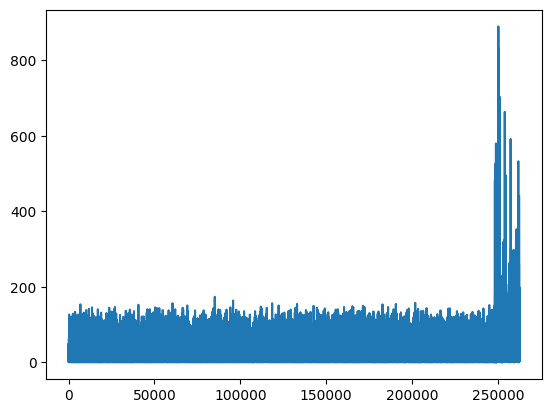

In [6]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [7]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
# print(X_train.shape)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941   .25
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
print(X_train.shape)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42) # .1764705882352941   .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(210161,)
(210161,)
(26270,)
(26271,)


In [9]:
X_train.shape

(210161,)

In [10]:
y_train.shape

(210161,)

In [11]:
X_test.shape

(26270,)

In [12]:
y_test.shape

(26270,)

In [13]:
X_val.shape

(26271,)

In [14]:
y_val.shape

(26271,)

In [15]:
X_train.shape

(210161,)

In [16]:
y_train.shape

(210161,)

In [17]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [18]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [19]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=64) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

**Анализ датасета**

https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/src/dataset_analysis.ipynb

In [20]:
sequence_length=64

In [21]:
navec.get('<unk>').shape[0]

300

In [22]:
# X_train = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_train.flatten()
#     )
# ))

# X_val = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_val.flatten()
#     )
# ))

# X_test = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_test.flatten()
#     )
# ))


In [23]:
X_train.shape

(210161,)

**Build RNN model**

Model: "Glove-Navec_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 62, 256)           230656    
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 387,201
Trainable params: 387,201
Non

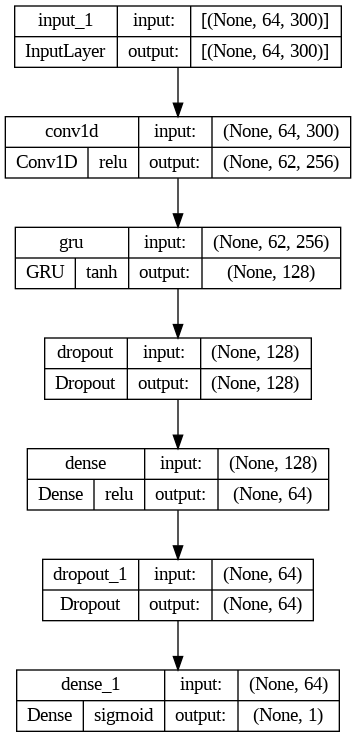

In [24]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Conv1D,GlobalMaxPool1D,SpatialDropout1D,GRU
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
EPOCHS = 13
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_CNN'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GRU(128, dropout=0.3, recurrent_dropout=0.1),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

# Пробуем

In [25]:
X_test[:2]

array(['классный фигурка',
       'я уехать по семейный обстоятельство родитель быть пожилой они хотеться на родина дожить себя дом'],
      dtype=object)

In [26]:
import math
class Dataset(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.x))
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]
        ###################

        batch_x = np.array(list(map(
            lambda sentence:vectorize_sentence(
                sentence,
                vectorizer=navec,
                unc_token =NAVEC_UNK,
                pad_token = NAVEC_PAD,
                max_sequence_length=sequence_length),
            batch_x.ravel()
            )
        ))

        ###################

        return batch_x, batch_y

In [27]:
BATCH_SIZE

512

In [28]:
train_gen = Dataset(x_set=X_train,y_set=y_train,batch_size=BATCH_SIZE)

val_gen = Dataset(x_set=X_val,y_set=y_val,batch_size=BATCH_SIZE)
x,y = train_gen.__getitem__(1)

In [29]:
x.shape

(512, 64, 300)

# ПРОБУЕМ 

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

# history = model.fit(
#     x=X_train,
#     y=y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_val,y_val),
#     callbacks=[early_stopping],
#     class_weight=calculate_weights(neutral_count, negative_count),
# )

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/13
411/411 [==============================] - 214s 479ms/step - loss: 0.6654 - tp: 17816.0000 - fp: 55759.0000 - tn: 114990.0000 - fn: 21596.0000 - accuracy: 0.6319 - precision: 0.2421 - recall: 0.4520 - auc: 0.6118 - prc: 0.3309 - val_loss: 0.4502 - val_tp: 4343.0000 - val_fp: 3521.0000 - val_tn: 17785.0000 - val_fn: 622.0000 - val_accuracy: 0.8423 - val_precision: 0.5523 - val_recall: 0.8747 - val_auc: 0.9067 - val_prc: 0.8195
Epoch 2/13
411/411 [==============================] - 193s 470ms/step - loss: 0.3638 - tp: 32217.0000 - fp: 20216.0000 - tn: 150533.0000 - fn: 7195.0000 - accuracy: 0.8696 - precision: 0.6144 - recall: 0.8174 - auc: 0.9141 - prc: 0.7887 - val_loss: 0.2807 - val_tp: 4492.0000 - val_fp: 2479.0000 - val_tn: 18827.0000 - val_fn: 473.0000 - val_accuracy: 0.8876 - val_precision: 0.6444 - val_recall: 0.9047 - val_auc: 0.9625 - val_prc: 0.8956
Epoch 3/13
411/411 [==============================] - 190s 462ms/step - loss: 0.2544 - tp: 34479.0000 - fp: 15520.0000 

**Save model**

In [31]:
model.save(MODEL_NAME)

In [32]:
X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))

In [33]:
pred = model.predict(X_test).flatten()

821/821 [==============================] - 17s 20ms/step


In [34]:
pred

array([0.00177005, 0.00827019, 0.01281887, ..., 0.00176178, 0.00539316,
       0.37739268], dtype=float32)

In [35]:
pred.shape

(26270,)

In [36]:
type(pred)

numpy.ndarray

In [37]:
pred[2]

0.012818873

In [38]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

In [39]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 21})
  plt.rc('axes', titlesize=16)
  plt.rc('axes', labelsize=14)
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  # plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.title('Матрица ошибок')
  plt.ylabel('Актуальное значение')
  plt.xlabel('Прогнозируемое значение')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  precision, recall, f1score = precision_recall_fscore_support(y_test, pred, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(y_test, pred,digits=4))
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 93.17 %
Recall: 86.62 %
Precision: 79.64 %
F1-score: 82.99 % 

precision: 0.881946088220039, recall: 0.9067506730478255, f1score: 0.8935623270582358
              precision    recall  f1-score   support

           0     0.9675    0.9473    0.9573     21216
           1     0.7964    0.8662    0.8299      5054

    accuracy                         0.9317     26270
   macro avg     0.8819    0.9068    0.8936     26270
weighted avg     0.9346    0.9317    0.9327     26270

True Negatives:  20097
False Positives:  1119
False Negatives:  676
True Positives:  4378


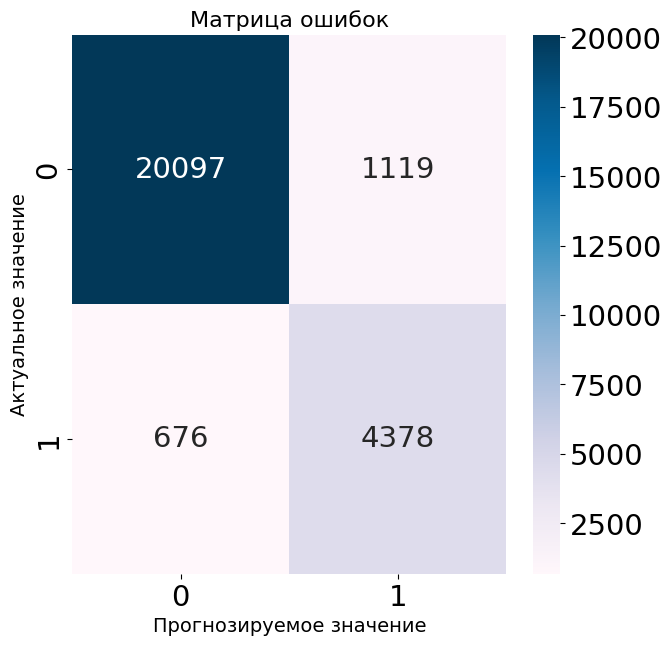

In [41]:
plot_cm(y_test, pred)

In [42]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

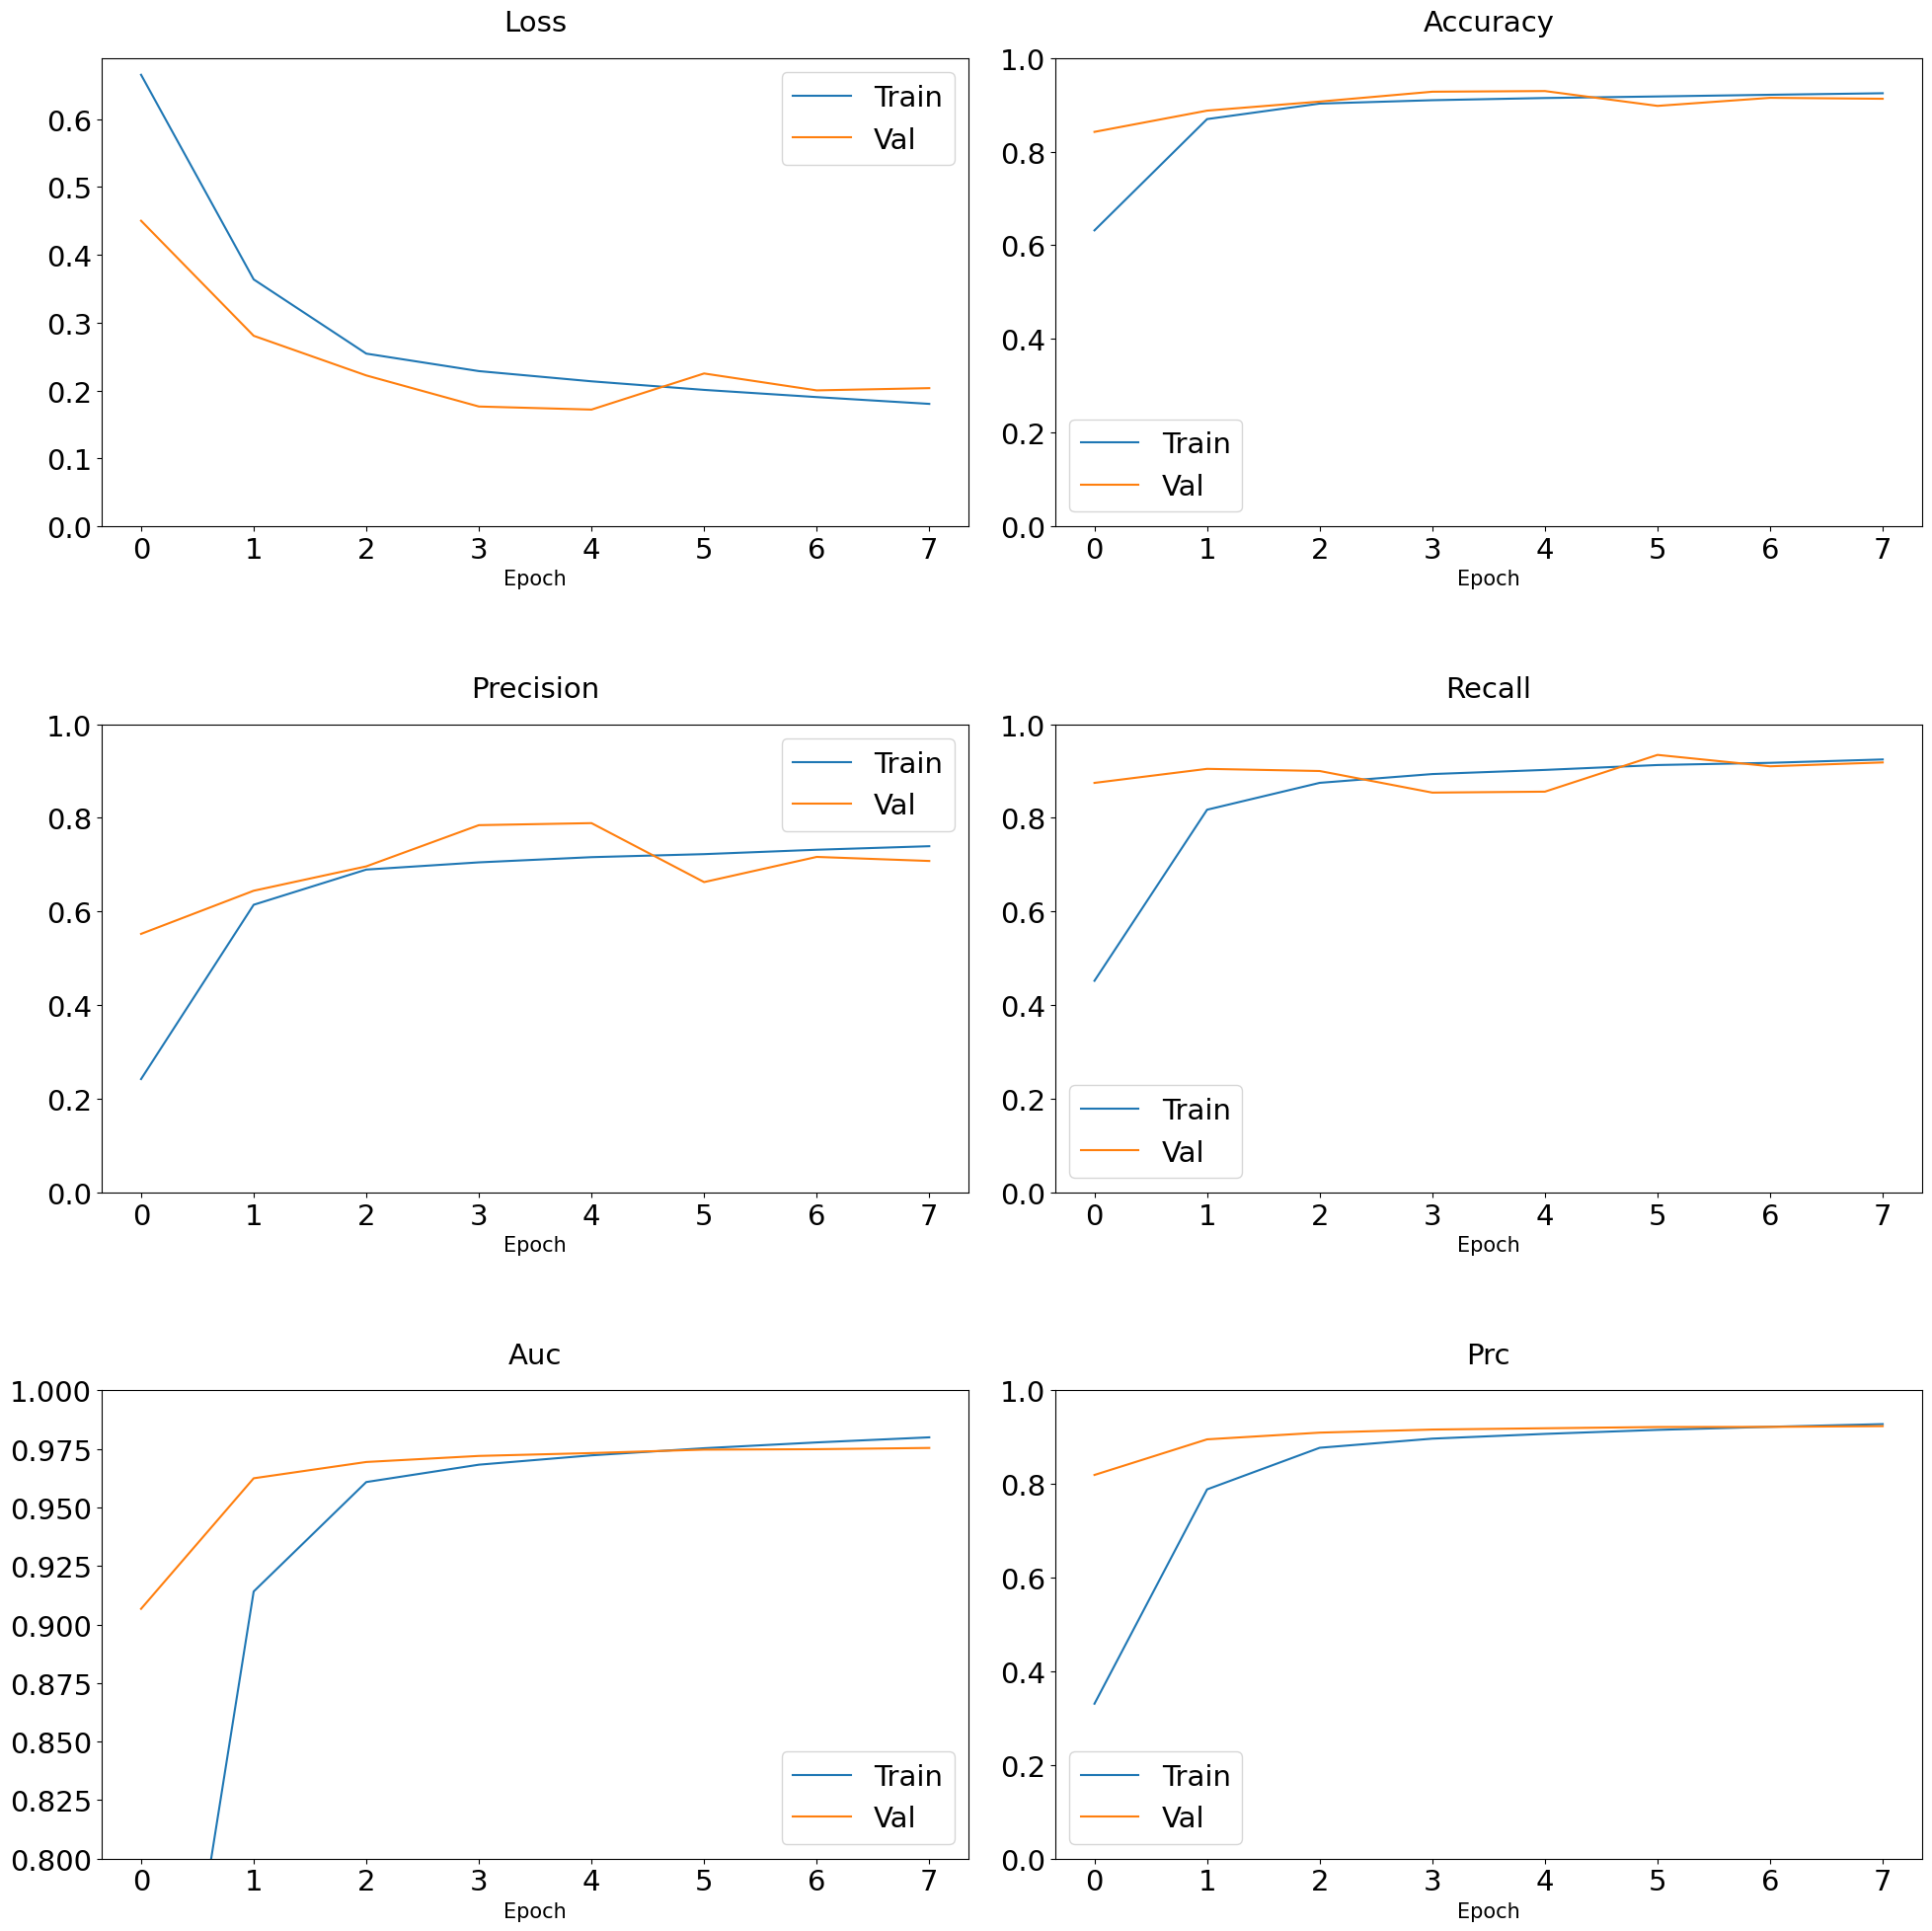

In [43]:
plot_metrics(history)

**Show ROC - curve**

821/821 [==============================] - 16s 20ms/step
: ROC AUC=0.976


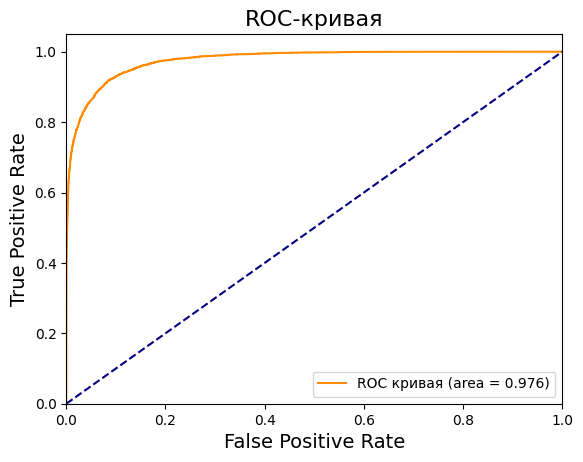

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = model.predict(X_test).flatten()
threshold =0.5
pred = np.where(pred<threshold,0,1)
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график

# размеры шрифта
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right",)
plt.show()